In [ ]:
## para instalar as dependencias no jupyter
## executar esta celular
! pip install -r ..requirements.txt

In [1]:
## bibliotecas necessarias
import librosa 
import matplotlib.pyplot as plt 
import numpy as np
import pickle as pkl
from datetime import datetime
from IPython.display import Audio # play audio, funciona apenas no jupyter
from auth_audio import AudioAuth
from sklearn.mixture import GaussianMixture
import pyaudio
%reload_ext auth_audio

In [2]:
MEDIA_PATH = '../media'
TRAIN_FILE_PATH = F'{MEDIA_PATH}/train'
TEST_FILE_PATH = F'{MEDIA_PATH}/test'
sr = 44100

In [3]:
aa = AudioAuth()

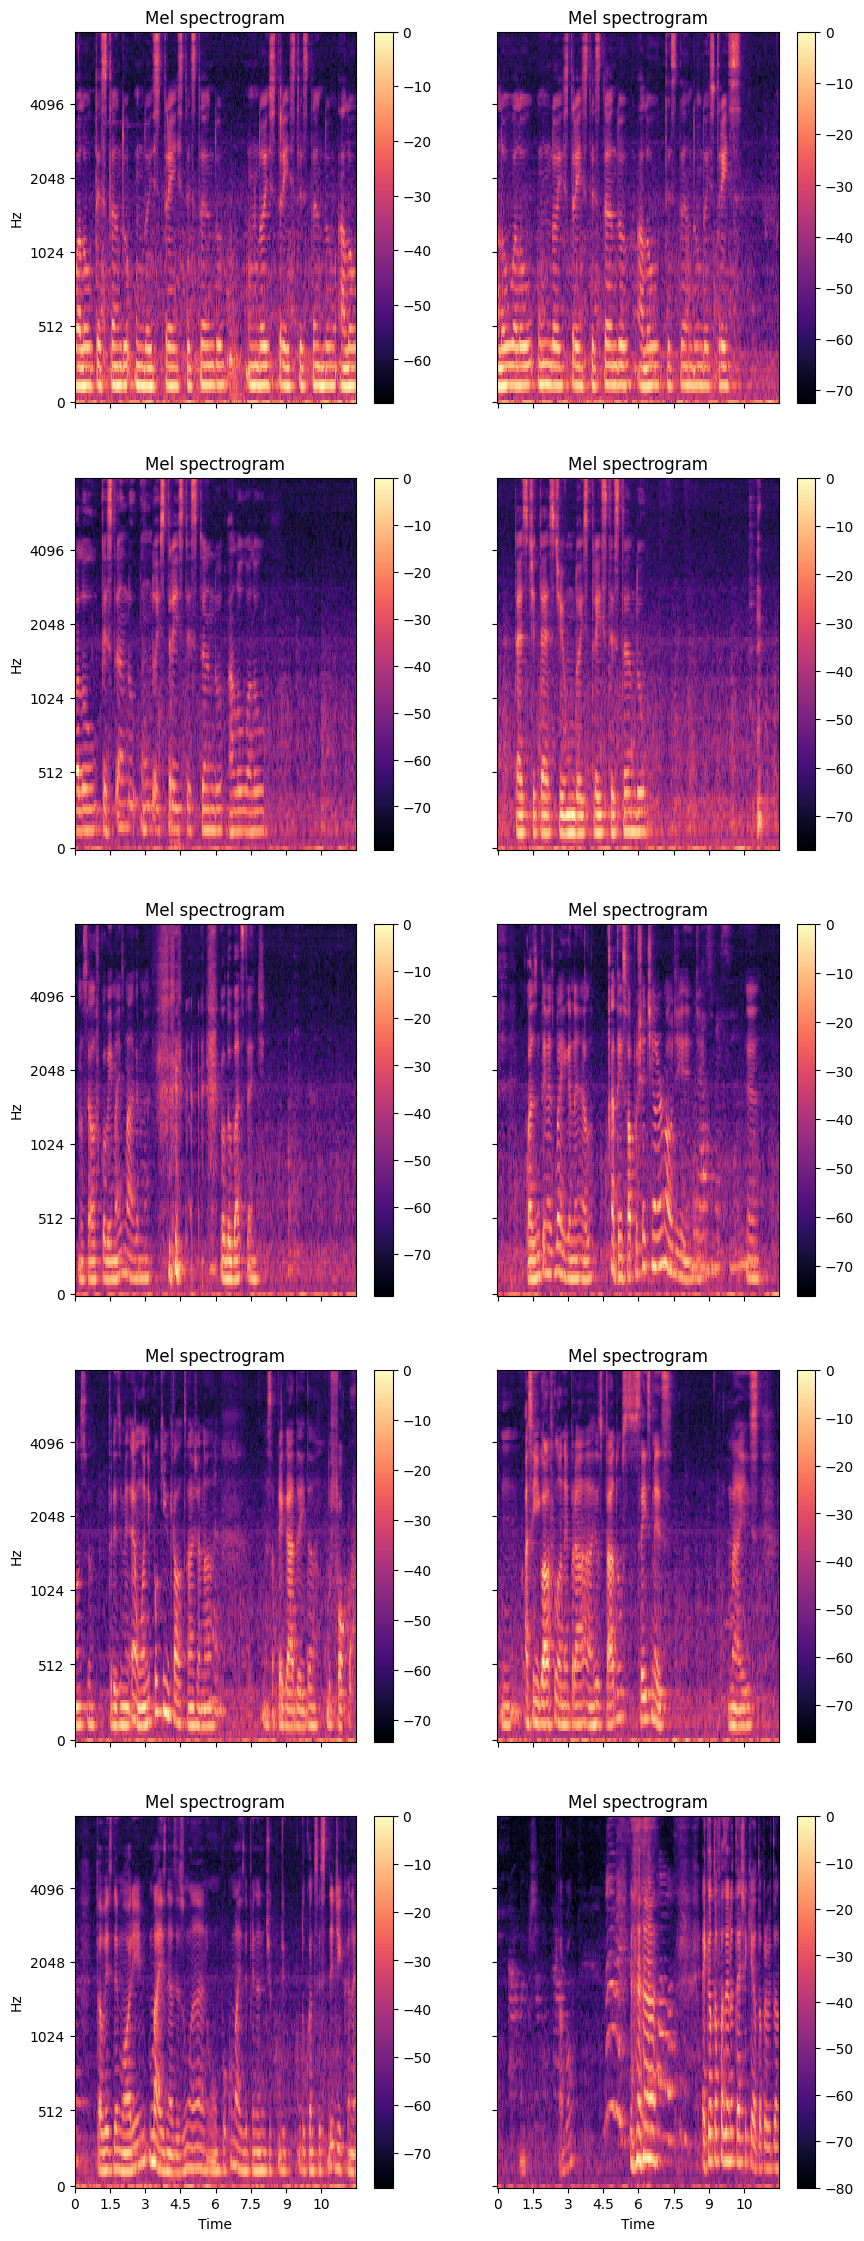

In [64]:
fig, axs = plt.subplots(5,2, figsize=(10,28))


for ax, i in zip(axs.flatten(), range(1,11)):
    filename = f'{TRAIN_FILE_PATH}/voice_{i}.wav'
    y, sr = librosa.load(filename, sr=sr)


    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                   fmax=8000)

    img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,

                               ax=ax)

    fig.colorbar(img, ax=[ax])
    ax.set(title='Mel spectrogram')
    ax.label_outer()

    # mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=128, dct_type=3)
    # img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)

    # fig.colorbar(img, ax=[ax])

    # ax.set(title='MFCC')



plt.show()

In [317]:
import numpy as np
from sklearn import preprocessing
from python_speech_features import mfcc
from python_speech_features import delta


class FeaturesExtractor:
    def __init__(self):
        pass

    def extract_features(self, audio, rate):
        """
        Extract voice features including the Mel Frequency Cepstral Coefficient (MFCC)
        from an audio using the python_speech_features module, performs Cepstral Mean
        Normalization (CMS) and combine it with MFCC deltas and the MFCC double
        deltas.
        Args:
            audio_path (str) : path to wave file without silent moments.
        Returns:
            (array) : Extracted features matrix.
        """
        mfcc_feature = mfcc(# The audio signal from which to compute features.
                            audio,
                            # The samplerate of the signal we are working with.
                            rate,
                            # The length of the analysis window in seconds.
                            # Default is 0.025s (25 milliseconds)
                            winlen       = 0.025,
                            # The step between successive windows in seconds.
                            # Default is 0.01s (10 milliseconds)
                            winstep      = 0.01,
                            # The number of cepstrum to return.
                            # Default 13.
                            numcep       = 128,
                            # The number of filters in the filterbank.
                            # Default is 26.
                            nfilt        = 16,
                            # The FFT size. Default is 512.
                            nfft         = 2048,
                            # If true, the zeroth cepstral coefficient is replaced
                            # with the log of the total frame energy.
                            appendEnergy = True)


        mfcc_feature  = preprocessing.scale(mfcc_feature)
        deltas        = delta(mfcc_feature, 2)
        double_deltas = delta(deltas, 2)
        combined      = np.hstack((mfcc_feature, deltas, double_deltas))
        return combined

    def accelerated_get_features_vector(self, input_wave_file, audio, sound_rate):
        """
        Get voice features from an input wave file faster.
        Args:
            input_wave_file (str) : Path to input wave file.
            audio       (ndarray) : Array representing the wave data.
            sound_rate      (int) : Rate of the audio.
        Returns:
            (array) with the voice features if the extraction was successful else [].
        """
        # extract features
        try   :
            return self.extract_features(audio, sound_rate)

        except:
            print("Cannot extract features from", input_wave_file.split('/')[-1])
            return np.array([])

In [318]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [319]:
fe = FeaturesExtractor()

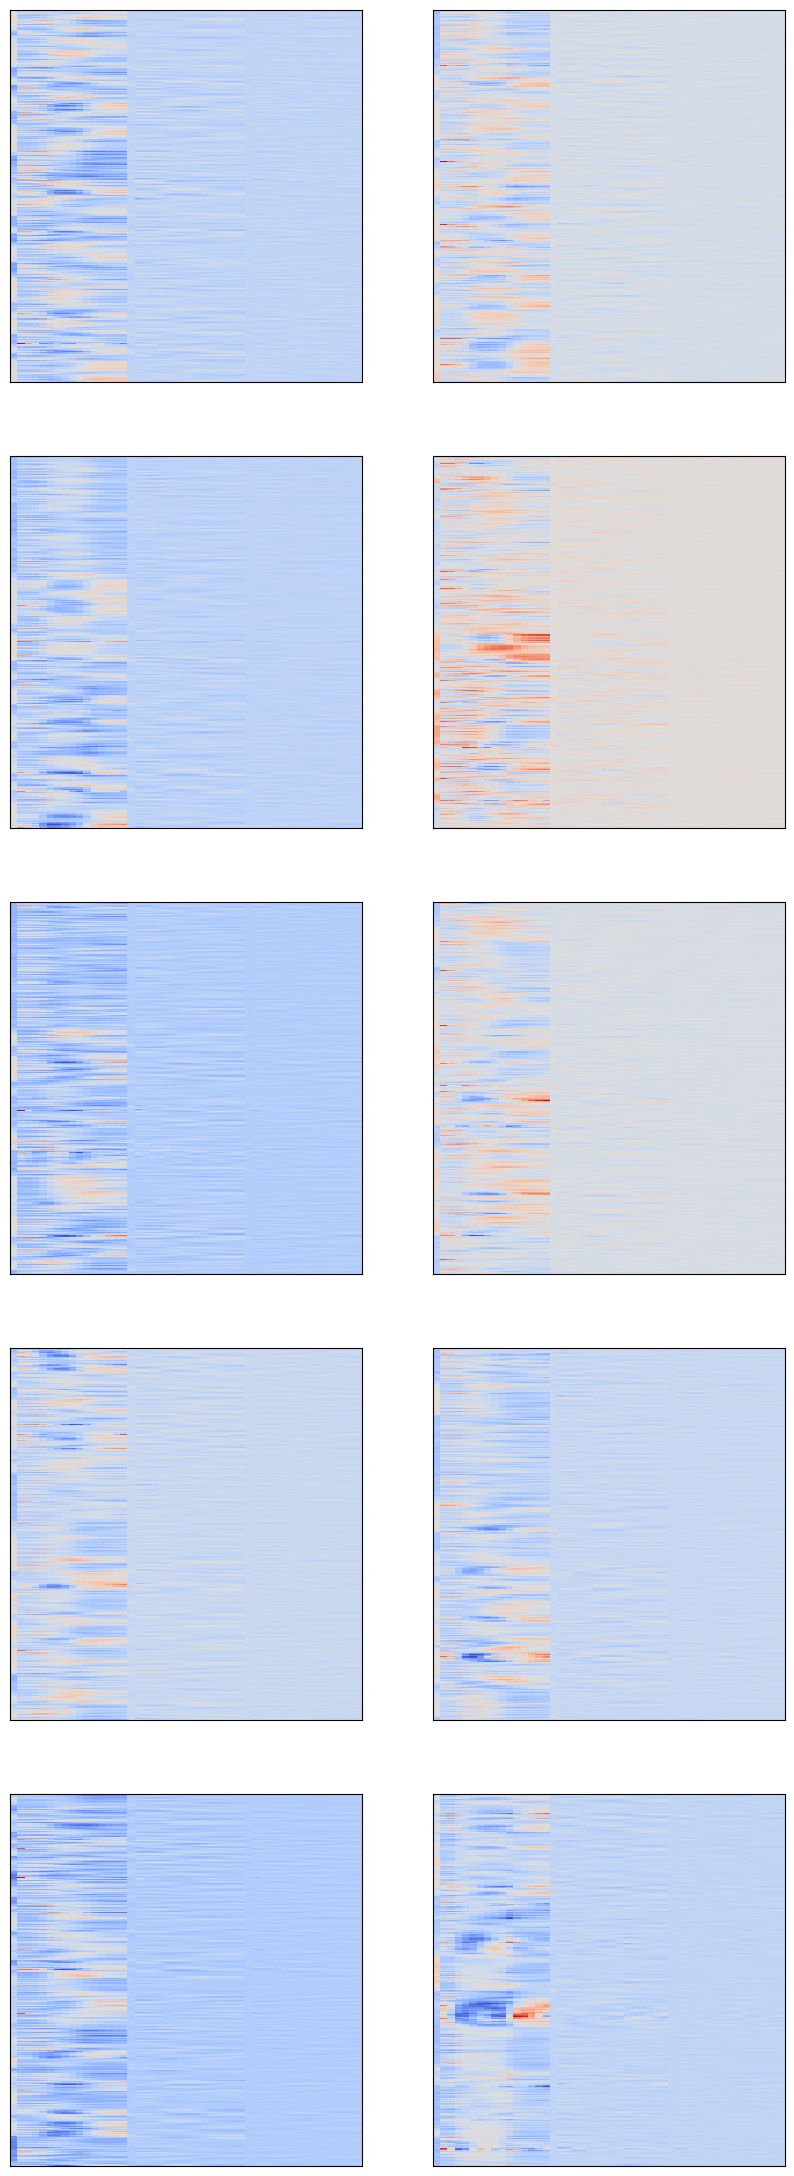

In [111]:
fig, axs = plt.subplots(5,2, figsize=(10,28))


for ax, i in zip(axs.flatten(), range(1,11)):
    filename = f'{TRAIN_FILE_PATH}/voice_{i}.wav'
    data, sr = librosa.load(filename, sr=sr)
    y = butter_bandpass_filter(data, 50, 255, sr, 3)
    features = fe.extract_features(y,sr)
    librosa.display.specshow(features, ax=ax)
plt.show()

In [329]:
filename = f'{TRAIN_FILE_PATH}/voice_1.wav'
y, sr = librosa.load(filename, sr=sr)
y = butter_bandpass_filter(y, 80, 170, sr, 3)
features = fe.extract_features(y,sr)
# features = features.reshape(1, features.shape[0] * features.shape[1])

gmm = GaussianMixture(n_components = 16, max_iter = 100, covariance_type='tied', n_init = 5, random_state=42)
# gmm = GaussianMixture()
gmm.fit(features)


GaussianMixture(covariance_type='tied', n_components=16, n_init=5,
                random_state=42)

In [337]:
for i in range(1,6):
    filename = f'{TEST_FILE_PATH}/voice_{i}.wav'
    # filename = f'{TRAIN_FILE_PATH}/voice_{i}.wav'
    y, sr = librosa.load(filename, sr=sr)
    y = butter_bandpass_filter(y, 80, 170, sr, 3)
    features = fe.extract_features(y,sr)

    # features = features.reshape(1, features.shape[0] * features.shape[1])
    print(filename, gmm.score(features))


../media/test/voice_1.wav 16.02069546822791
../media/test/voice_2.wav -467.4724419099192
../media/test/voice_3.wav -156.56386872142153
../media/test/voice_4.wav -4686.414169409917
../media/test/voice_5.wav -568.3748965579917
